# Function superresolution

In this task we will use simulated data for super-resolution, where we want to learn how to reconstruct high-resolution signals from low-resolution observations.

In [463]:
# Import necessary libaries
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

## Generating the simulated signals from a Fourier series

In [464]:
# Data is sampled from a truncated Fourier series
def generateData(x, downscale_factor=5, no_samples=1000, no_waves=5):
    """
    x: The input grid (e.g., a 1D array of x-values) where the signals are evaluated.
    no_waves: The maximum number of sine waves to combine to create each signal.
    """
    uall = []  # high-resolution signals
    uall_lr = []  # low-resolution signals

    for j in range(no_samples):
        waves = np.random.randint(1, no_waves)
        u = 1 / (2 * np.pi)  # signal initialization
        for i in range(waves):
            amplitude = np.random.randn()  # randomly pick get an amplitude
            u += amplitude * np.sin(
                np.pi * (i + 1) * x
            )  # fourier series (with sine only)
        u = u / np.max(u)  # signal

        uall.append(u)
        uall_lr.append(u[::downscale_factor])

    return [np.array(uall_lr), np.array(uall)]

In [465]:
# Generate some training data
no_points = 101
downscale_factor = 4
no_samples = 100

# High res grid
x = np.linspace(-np.pi, np.pi, no_points)

# Low res grid
x_lr = x[::downscale_factor]

# Generated high/low res solutions
[u_lr, u] = generateData(x, downscale_factor, no_samples)

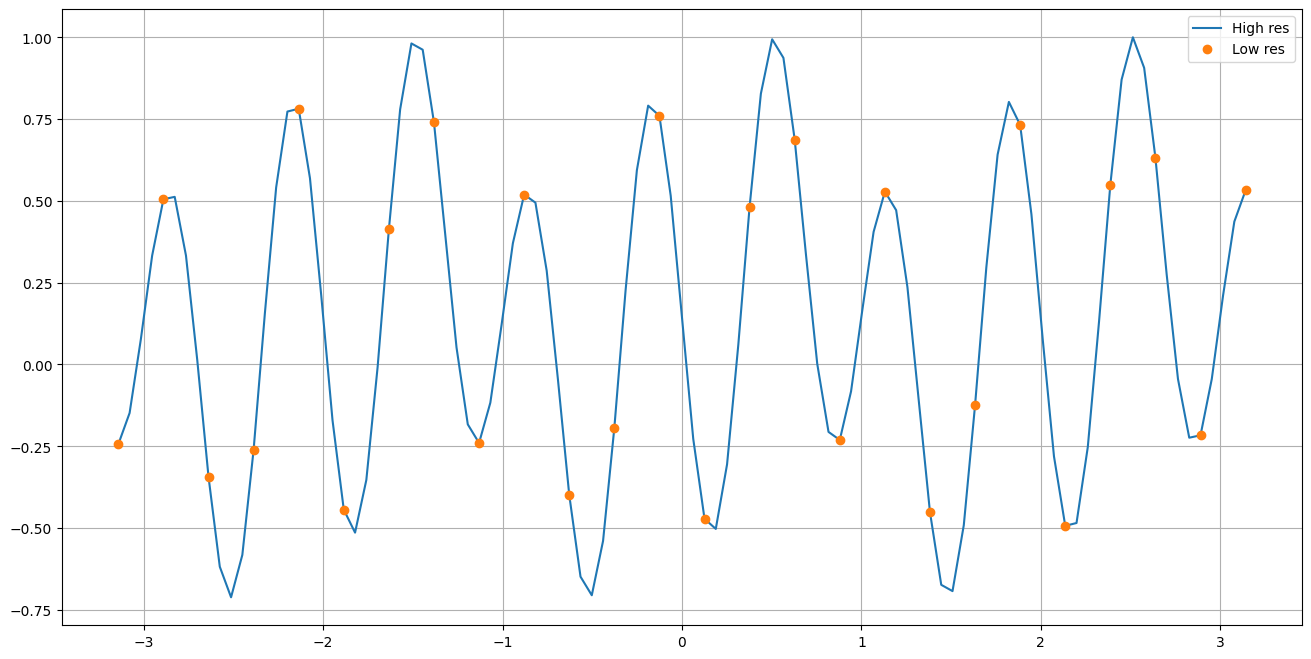

In [466]:
# Visualize some training samples
ix = np.random.randint(u.shape[0])

plt.figure(figsize=(16, 8))
plt.plot(x, u[ix,])
plt.plot(x_lr, u_lr[ix,], "o")
plt.grid()
plt.legend(["High res", "Low res"])
plt.show()

## Model Building and Training

In [467]:
# Import neccessary ml libraries
import tensorflow as tf

Here we are saying that our `X_train` is `u_lr `(signal of low resolution) and our `y_train` is `u` ( the signal with all generated points). with coarsening or downscaling factor of 4, the `input_shape = 26` and `output_shape = 100`.

In [468]:
u_lr.shape

(100, 26)

In [469]:
u.shape

(100, 101)

In [470]:
inp = tf.keras.layers.Input(shape=(26,))
b = tf.keras.layers.Dense(128, activation="relu")(inp)
b = tf.keras.layers.Dense(128, activation="relu")(b)
# x = tf.keras.layers.Dense(32, activation='relu')(b)
out = tf.keras.layers.Dense(101, activation="linear")(b)

model = tf.keras.Model(inp, out)

model.compile(optimizer="adam", loss="mse", metrics=["mse"])

history = model.fit(u_lr, u, batch_size=1, epochs=500, verbose=0, validation_split=0.2)

## Model Evaluation

In [471]:
import pandas as pd

hist = pd.DataFrame(history.history)
hist.tail()

,loss,mse,val_loss,val_mse
495,0.000507,0.000507,0.001799,0.001799
496,0.000645,0.000645,0.001804,0.001804
497,0.000392,0.000392,0.001834,0.001834
498,0.000836,0.000836,0.001939,0.001939
499,0.000798,0.000798,0.002035,0.002035


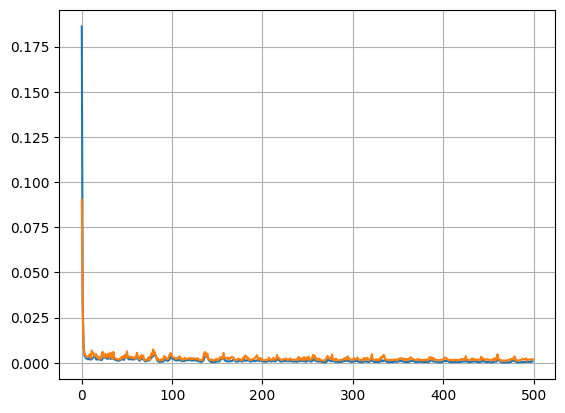

In [472]:
plt.plot(hist.mse)
plt.plot(hist.val_mse)
plt.grid()
plt.show()

## Model Predictions

In [473]:
# x = np.linspace(-np.pi, np.pi, no_points)
[test_lr, test_hr] = generateData(x, downscale_factor=4, no_samples=15)

pred = model.predict(test_lr)

1/1 [==============================] - 0s 24ms/step


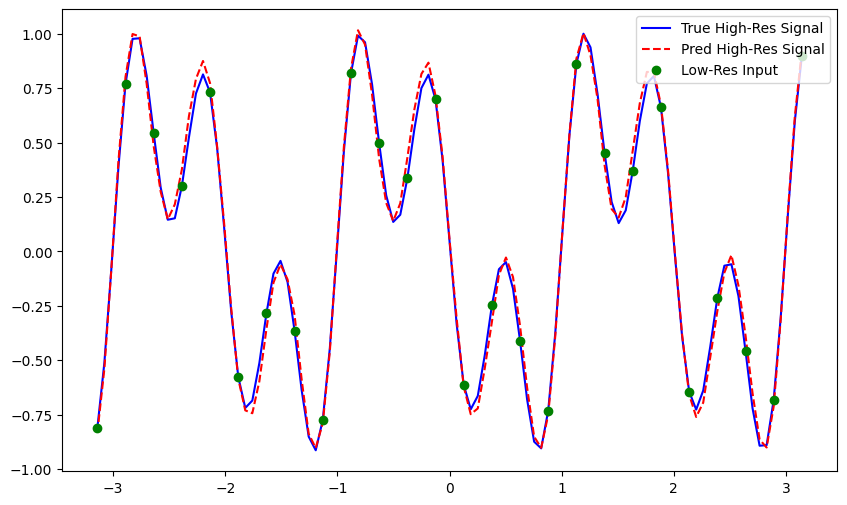

In [474]:

sample_index = np.random.randint(pred.shape[0])  

plt.figure(figsize=(10, 6))
plt.plot(x, test_hr[sample_index], label="True High-Res Signal", color='blue')
plt.plot(x, pred[sample_index], label="Pred High-Res Signal", linestyle='--', color='red')
plt.plot(x_lr, test_lr[sample_index], 'o', label="Low-Res Input", color='green')
plt.legend()
plt.show()